In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


Import data

In [0]:
uploaded = files.upload()

Saving Dummy_data.csv to Dummy_data.csv


In [0]:
df = pd.read_csv(io.BytesIO(uploaded['Dummy_data.csv']))

In [0]:
df.head()

,SAT 1,SAT 2,SAT 3,SAT 4,SAT 5,SAT 6,SAT 7,SAT 8,SAT 9,SAT 10,SAT 11
0,0.0,0.0,3.60197,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,4.11306,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,4.75834,2.90820,0.0,0.0,0.0,0.0,2.61194,0.0,0.0
3,0.0,0.0,5.57709,3.01929,0.0,0.0,0.0,0.0,3.17880,0.0,0.0
4,0.0,0.0,6.62263,3.27989,0.0,0.0,0.0,0.0,3.78744,0.0,0.0


In [0]:
features_considered = ['SAT 1', 'SAT 2', 'SAT 3','SAT 4', 'SAT 5', 'SAT 6','SAT 7', 'SAT 8', 'SAT 9','SAT 10', 'SAT 11']
features = df[features_considered]
features.head()

,SAT 1,SAT 2,SAT 3,SAT 4,SAT 5,SAT 6,SAT 7,SAT 8,SAT 9,SAT 10,SAT 11
0,0.0,0.0,3.60197,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,4.11306,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,4.75834,2.90820,0.0,0.0,0.0,0.0,2.61194,0.0,0.0
3,0.0,0.0,5.57709,3.01929,0.0,0.0,0.0,0.0,3.17880,0.0,0.0
4,0.0,0.0,6.62263,3.27989,0.0,0.0,0.0,0.0,3.78744,0.0,0.0


In [0]:
TRAIN_SPLIT = 7000
tf.random.set_seed(13)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1d512ff60>,
      dtype=object)

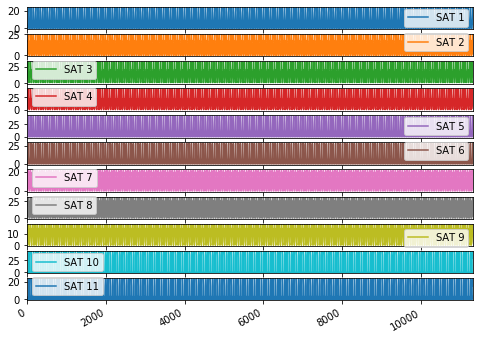

In [0]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
  # i is the present moment, we take past samples from i-history_size (sampled), 
  # then from i onward we take a target_size points for predicted plot 
  # (output/label) or 1 point for single step

Generte train and val 

In [0]:
past_history = 30 # to change
future_target = 5 # to change
STEP = 1 # to change



x_train_multi, y_train_multi = multivariate_data(dataset, dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi.shape))
print ('\n Target window to predict : {}'.format(y_train_multi.shape))
print ('\n Train data size : {}'.format(x_val_multi.shape))
print ('\n Val data size : {}'.format(y_val_multi.shape))

Single window of past history : (6970, 30, 11)

 Target window to predict : (6970, 5, 11)

 Train data size : (4293, 30, 11)

 Val data size : (4293, 5, 11)


In [0]:
y_train_multi = y_train_multi.reshape(6970,5*11)
y_val_multi = y_val_multi.reshape(4293,5*11)

Create batch and buffer and shuffle them

In [0]:
BATCH_SIZE =  256 # to channge
BUFFER_SIZE = 10000 # to change

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future),  
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction),
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

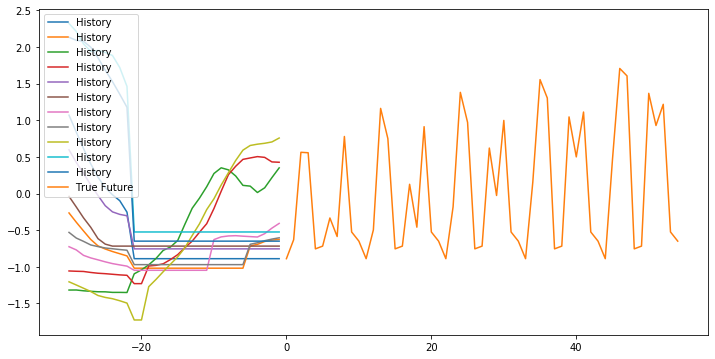

In [0]:
#for x, y in train_data_multi.take(1):
#  multi_step_plot(x[0], y[0], np.array([0]))

Create the network 

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5*11))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
# check network and input shape!

In [0]:
for x, y in val_data_multi.take(1):
  out = multi_step_model.predict(x).reshape(256,5,11)
  print (out.shape)
  print(y.shape)

(256, 5, 11)
(256, 55)


In [0]:
EVALUATION_INTERVAL = 400
EPOCHS = 10


multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/10
400/400 [==============================] - 14s 36ms/step - loss: 0.0675 - val_loss: 0.0651
Epoch 2/10
400/400 [==============================] - 14s 35ms/step - loss: 0.0638 - val_loss: 0.0617
Epoch 3/10
400/400 [==============================] - 14s 36ms/step - loss: 0.0607 - val_loss: 0.0576
Epoch 4/10
400/400 [==============================] - 14s 35ms/step - loss: 0.0577 - val_loss: 0.0560
Epoch 5/10
400/400 [==============================] - 14s 35ms/step - loss: 0.0550 - val_loss: 0.0521
Epoch 6/10
400/400 [==============================] - 14s 36ms/step - loss: 0.0524 - val_loss: 0.0519
Epoch 7/10
400/400 [==============================] - 15s 36ms/step - loss: 0.0502 - val_loss: 0.0520
Epoch 8/10
400/400 [==============================] - 14s 35ms/step - loss: 0.0484 - val_loss: 0.0461
Epoch 9/10
400/400 [==============================] - 14s 35ms/step - loss: 0.0468 - val_loss: 0.0466
Epoch 10/10
400/400 [==================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

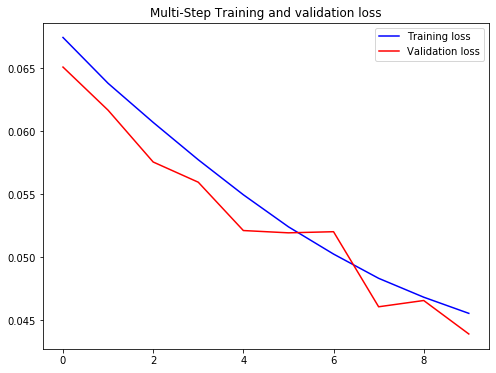

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

(256, 5, 11)


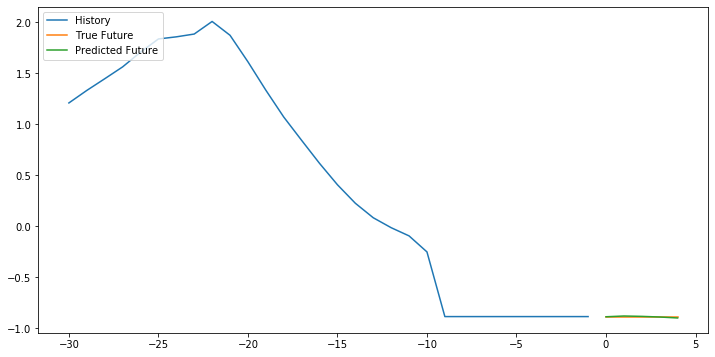

(256, 5, 11)


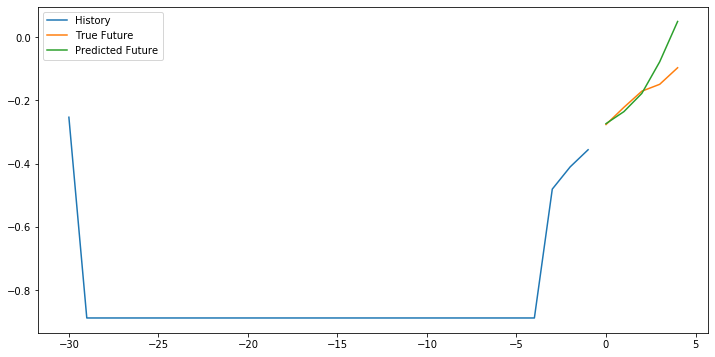

(256, 5, 11)


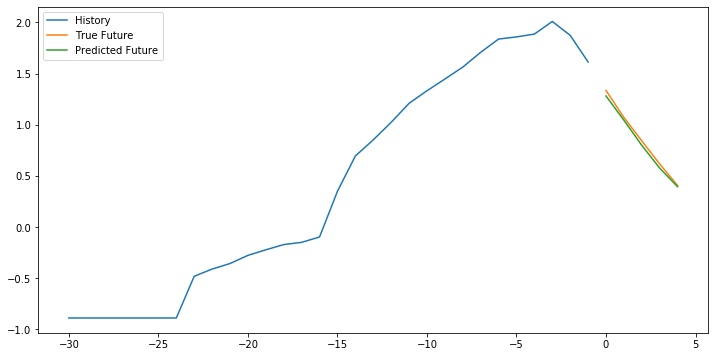

(256, 5, 11)


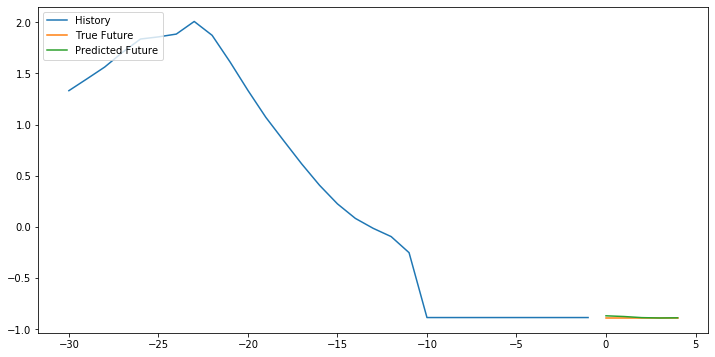

(256, 5, 11)


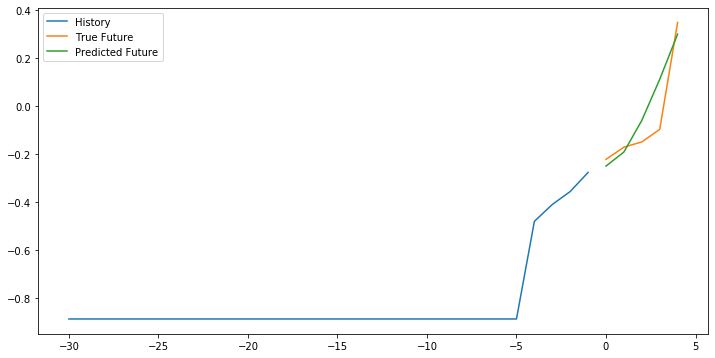

(256, 5, 11)


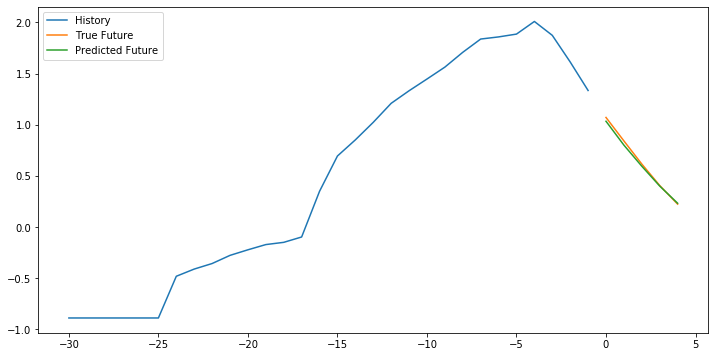

(256, 5, 11)


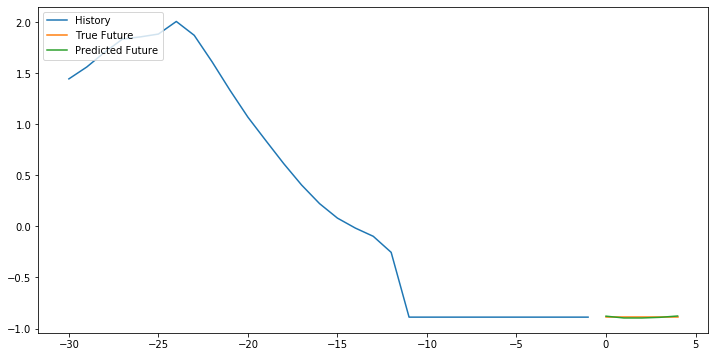

(256, 5, 11)


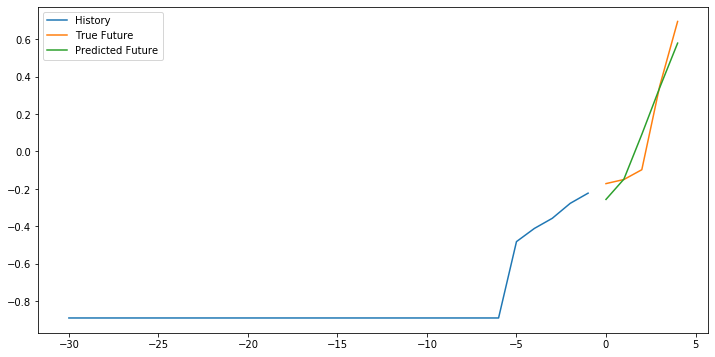

(256, 5, 11)


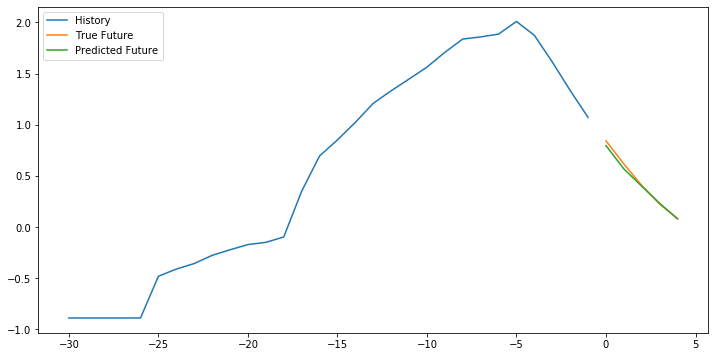

(256, 5, 11)


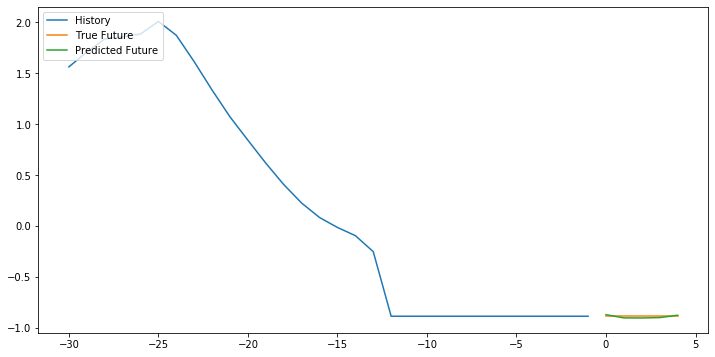

In [0]:
for x, y in val_data_multi.take(10):
  out = multi_step_model.predict(x)
  out = out.reshape(256,5,11)
  y = y.numpy()
  y = y.reshape(256,5,11)
  print(y.shape)
  multi_step_plot(x[0,:,0], y[0,:,0], out[0,:,0])